#Setting up PySpark

In [ ]:
!apt-get install openjdk-8-jdk-headless

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2023-05-17 18:45:47--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz.2’

spark-3.2.1-bin-had 100%[===================>] 260.01M  99.8KB/s    in 44m 27s 

2023-05-17 19:30:14 (99.8 KB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz.2’ saved [272637746/272637746]



In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz.2

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("DataCleaningApp")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

## Load Data to PySpark

In [ ]:
#First downlad the file from moodle and then upload it to the colab
df = spark.read.csv("/content/ad-clicks.csv", header=True, inferSchema=True)

AnalysisException: ignored

In [ ]:
df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- teamchat_session_id: integer (nullable = true)
 |-- date: integer (nullable = true)



In [ ]:
df.show(5)

+-------+-------------------+----------+
|user_id|teamchat_session_id|      date|
+-------+-------------------+----------+
|   1588|               6776|1464233999|
|    350|               6777|1464234000|
|    740|               6778|1464234001|
|   1068|               6779|1464234002|
|   1554|               6780|1464234003|
+-------+-------------------+----------+
only showing top 5 rows



In [ ]:
df.describe()

DataFrame[summary: string, user_id: string, teamchat_session_id: string, date: string]

In [ ]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
user_id,4001,1044.889777555611,604.0258422435047,1,2100
teamchat_session_id,4001,8873.222944263935,6091.211665406428,6776,62531
date,4001,1.4652051334216447E9,545178.8420192328,1464233999,1466032311


In [ ]:
df.count()

4001

## Find Count of null, None, NaN Values

In [ ]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()


## Find duplicates

In [ ]:
df_updated = df.distinct()

In [ ]:
df_updated.count()

4001

In [ ]:
df_updated.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- teamchat_session_id: integer (nullable = true)
 |-- date: integer (nullable = true)



## 1. Most Popular User Platform

In [ ]:
user_session_df = spark.read.csv("/content/user-session.csv", header=True, inferSchema=True)

In [ ]:
user_session_df.show(5)

+-------------------+-------------+------+------+------------+-----------+---------+------------+
|          timestamp|userSessionId|userId|teamId|assignmentId|sessionType|teamLevel|platformType|
+-------------------+-------------+------+------+------------+-----------+---------+------------+
|2016-05-26 14:47:30|         5675|   170|    90|        5423|      start|        1|      iphone|
|2016-05-27 00:06:54|         5675|   170|    90|        5423|        end|        1|      iphone|
|2016-05-26 14:43:09|         5795|   835|    39|        5300|      start|        1|     android|
|2016-05-27 08:06:54|         5795|   835|    39|        5300|        end|        1|     android|
|2016-05-26 14:47:20|         5833|   624|     2|        5529|      start|        1|      iphone|
+-------------------+-------------+------+------+------------+-----------+---------+------------+
only showing top 5 rows



+------------+-----+------------------+
|platformType|count|        percentage|
+------------+-----+------------------+
|      iphone| 3874| 41.88108108108108|
|     android| 3274|35.394594594594594|
|       linux|  504| 5.448648648648648|
|         mac|  358|  3.87027027027027|
|     windows| 1240|13.405405405405405|
+------------+-----+------------------+



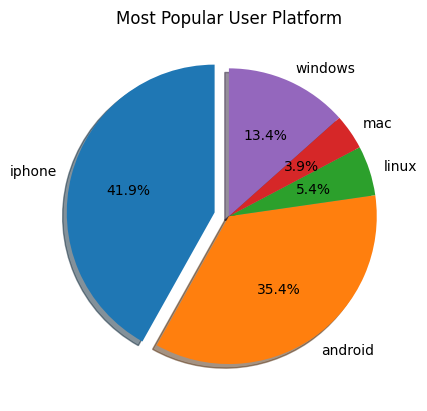

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

platform_users = user_session_df.groupby('platformType').agg(
    (F.count('userId')).alias('count'),
    (F.count('userId') / user_session_df.count() * 100).alias('percentage')
)

platform_users.show()

platform_users_data = platform_users.toPandas()

labels = platform_users_data['platformType']
sizes = platform_users_data['percentage']

explode = (0.1, 0, 0, 0,0)  # only "explode" the 1st slice (i.e. Web App)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.set_title("Most Popular User Platform")
plt.show()

## 2. Age Group of Players

In [ ]:
user_df = spark.read.csv("/content/users.csv", header=True, inferSchema=True)

In [ ]:
from pyspark.sql import functions as F

# Resource for below Code : https://stackoverflow.com/questions/62148704/date-difference-in-years-in-pyspark-dataframe

user_with_age_df = user_df.withColumn("age",(F.months_between(F.current_date(), F.col('dob')) / 12).cast('int'))

user_with_age_df.show(10)

+-------------------+------+-----------+----------+----------+-------+---+
|          timestamp|userId|       nick|   twitter|       dob|country|age|
+-------------------+------+-----------+----------+----------+-------+---+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA| 28|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU| 52|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS| 53|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM| 57|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC| 28|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH| 36|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM| 31|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ| 45|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|     PF| 71|
|2012-06-23 17:40:35|    75|     fNWewX|   @OXqLyv|1979-11-12|     JO| 43|
+-------------------+----

In [ ]:

from pyspark.sql.functions import udf


age_range = udf(lambda age: '< 20' if age < 20 else 
                       '20-29' if (age >= 20 and age < 30) else
                       '30-39' if (age >= 30 and age < 40) else
                       '40-49' if (age >= 40 and age < 50) else        
                       '50-59' if (age >= 50 and age < 60) else
                       '60-70' if (age >= 60 and age < 70) else
                       '70-79' if (age >= 70 and age < 79) else
                       '80-100' if (age >= 80 and age < 101)  else ""    
                       )

user_with_age_df = user_with_age_df.withColumn('age_group', age_range(user_with_age_df.age))
user_with_age_df.show()

+-------------------+------+-----------+----------+----------+-------+---+---------+
|          timestamp|userId|       nick|   twitter|       dob|country|age|age_group|
+-------------------+------+-----------+----------+----------+-------+---+---------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA| 28|    20-29|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU| 52|    50-59|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS| 53|    50-59|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM| 57|    50-59|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC| 28|    20-29|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH| 36|    30-39|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM| 31|    30-39|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ| 45|    40-49|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|   

In [ ]:

data = user_with_age_df.toPandas()
data.loc[data['age']<=19, 'age_group'] = 'teenage'
data.loc[data['age'].between(20,35), 'age_group'] = '20-35'
data.loc[data['age'].between(36,50), 'age_group'] = '36-50'
data.loc[data['age'].between(51,65), 'age_group'] = '51-65'
data.loc[data['age'].between(66,100), 'age_group'] = '66-100'

data

,timestamp,userId,nick,twitter,dob,country,age,age_group
0,2012-06-19 14:53:41,442,pcjIOBKW,@SZhyOHv,1994-07-20,BA,28,20-35
1,2012-06-19 19:29:01,949,vAOfUkf,@nkkNo,1971-04-22,HU,52,51-65
2,2012-06-20 19:34:59,1654,qOOXSQ,@SwOlw,1970-04-19,IS,53,51-65
3,2012-06-21 01:18:29,1586,px4gW51,@IrCHTnE,1965-11-23,AM,57,51-65
4,2012-06-21 15:35:00,599,9gkfwRC73Uc,@VJj0Az,1994-08-23,CC,28,20-35
...,...,...,...,...,...,...,...,...
2388,2016-06-11 05:17:17,2312,CJOHXgqKh,@ZomNVFWoF,1996-10-05,MT,26,20-35
2389,2016-06-14 03:19:04,100,lJexGia,@BYQ14xmNd,1987-05-25,CR,35,20-35
2390,2016-06-14 10:40:22,651,iynipG41EV,@nXTCcg7sV,1987-04-08,CI,36,36-50
2391,2016-06-15 16:33:25,2390,hH9wrFLdTt,@KimUIQF,1991-03-02,TK,32,20-35


In [ ]:

from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
import pyspark.sql.functions as f


window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

w = Window.partitionBy('x')

user_with_age_df_grouped = user_with_age_df.groupBy('age_group').count()\
        .select('age_group', f.col('count').alias('age_group_count'))\
        .sort(f.asc("age_group")) 


user_with_age_df_grouped.show()

+---------+---------------+
|age_group|age_group_count|
+---------+---------------+
|    20-29|            310|
|    30-39|            602|
|    40-49|            552|
|    50-59|            432|
|    60-70|            325|
|    70-79|            172|
+---------+---------------+



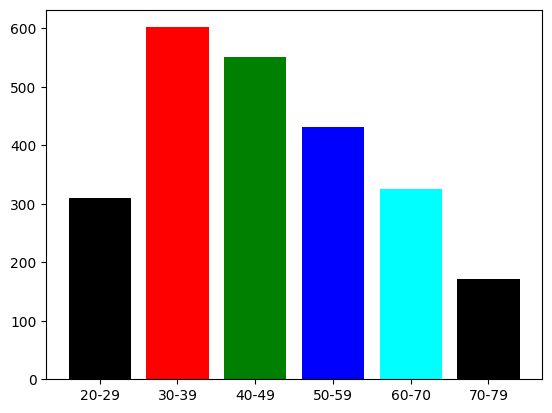

Text(0.5, 0, 'Age Group')

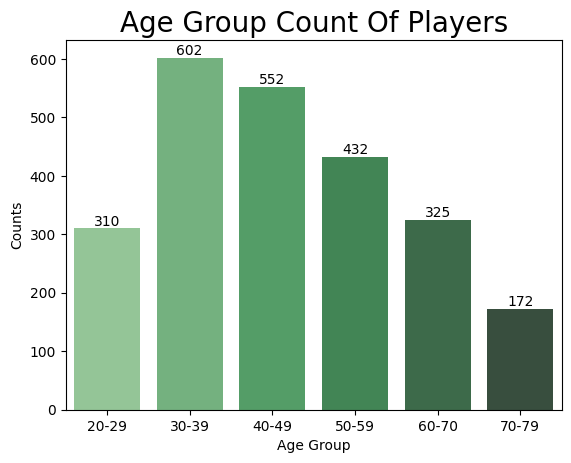

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
data = user_with_age_df_grouped.toPandas()
# create a dataset
height = data['age_group_count']
bars = data['age_group']
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['black', 'red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

###Seaborn bar plot

ax = sns.barplot(x = "age_group", y = "age_group_count", data = data ,palette='Greens_d')

ax.bar_label(ax.containers[0])

plt.title("Age Group Count Of Players", fontsize=20)
plt.ylabel('Counts')
plt.xlabel('Age Group')

## 3. Top spending teams

In [ ]:
buy_df = spark.read.csv("/content/buy-clicks.csv", header=True, inferSchema=True)

In [ ]:
buy_df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- txId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- team: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- buyId: integer (nullable = true)
 |-- price: double (nullable = true)



In [ ]:
buy_df.show()

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|  11|  2222|    5| 20.0|
|2016-05-26 17:06:54|6094|         5798|  77|  1304|    5| 20.0|
|2016-05-26 18:06:54|6155|         5920|   9|  1027|    5| 20.0|
|2016-05-26 18:06:54|6156|         5697|  35|  2199|    2|  3.0|
|2016-05-26 18:36:54|6183|         5893|  64|  1544|    5| 20.0|
|2016-05-26 18:36:54|6184|         5697|  35|  2199|    1|  2.0|
|2016-05-26 19:36:54|6243|         5659|  13|  1623|    4| 10.0|
|2016-05-26 19:36:54|6244|         5920|   9|  1027|    3|  5.0|
|2016-05-26 20:06:54|6269

In [ ]:
from pyspark.sql.functions import desc

team_spend_df = buy_df.groupBy('team').sum('price').orderBy(desc("sum(price)")).limit(15)


In [ ]:
team_spend_df.show()

+----+----------+
|team|sum(price)|
+----+----------+
|  27|     880.0|
|  54|     777.0|
|  35|     710.0|
|  64|     693.0|
|  53|     677.0|
|  66|     647.0|
|  59|     644.0|
|  11|     587.0|
|  97|     549.0|
|  22|     535.0|
|  72|     534.0|
|   9|     513.0|
|  20|     458.0|
|  94|     450.0|
|  13|     448.0|
+----+----------+



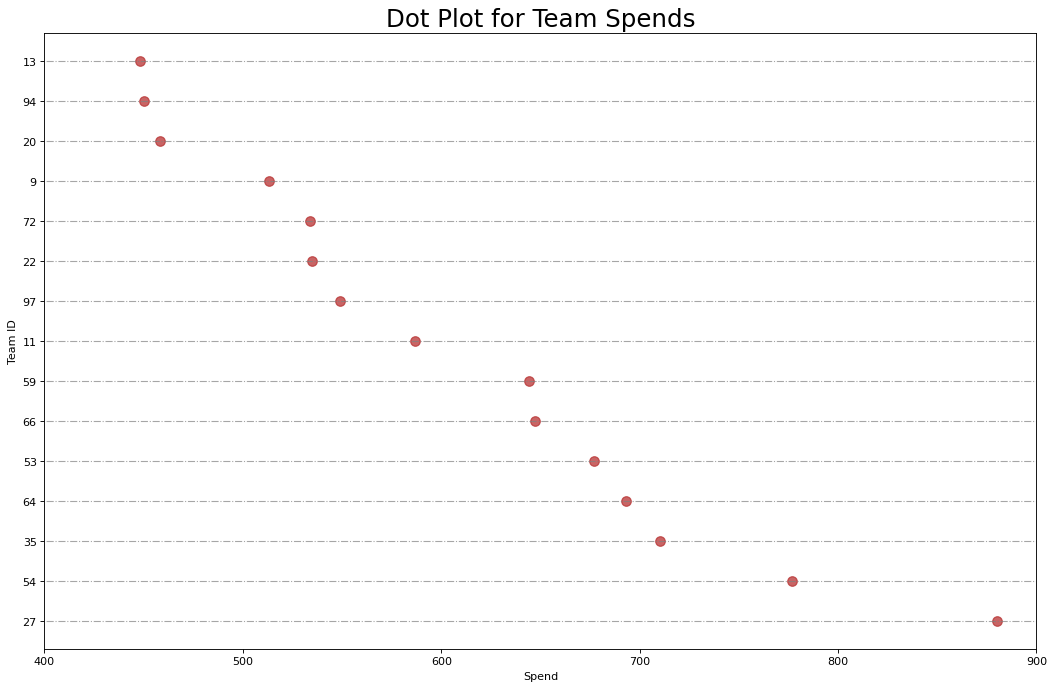

In [ ]:
#Dot plot visualisation
import matplotlib.pyplot as plt

df = team_spend_df.toPandas()
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=df.index, xmin=100, xmax=900, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=df.index, x=df['sum(price)'], s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Dot Plot for Team Spends', fontdict={'size':22})
ax.set_xlabel('Spend')
ax.set_ylabel('Team ID')
ax.set_yticks(df.index)
ax.set_yticklabels(df['team'], fontdict={'horizontalalignment': 'right'})
ax.set_xlim(400, 900)
plt.show()

## 4. Team spending and Team Strength

In [ ]:
team_df = spark.read.csv("/content/team.csv", header=True, inferSchema=True)

In [ ]:
team_df.printSchema()

root
 |-- teamId: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- teamCreationTime: string (nullable = true)
 |-- teamEndTime: string (nullable = true)
 |-- strength: double (nullable = true)
 |-- currentLevel: integer (nullable = true)



In [ ]:
team_df.show(5)

+------+----------+-------------------+-------------------+--------------+------------+
|teamId|      name|   teamCreationTime|        teamEndTime|      strength|currentLevel|
+------+----------+-------------------+-------------------+--------------+------------+
|    79|   O1uJX7C|2016-06-12 15:33:27|9999-12-31 23:59:59|0.774473575316|           1|
|    92|  WeLHp8HZ|2016-06-12 21:54:20|9999-12-31 23:59:59| 0.17192602642|           1|
|     6|    mARlfz|2016-06-12 23:02:16|9999-12-31 23:59:59|0.537353043526|           1|
|     7|xO41jlAo0Y|2016-06-13 06:03:03|9999-12-31 23:59:59|0.394370370549|           1|
|    40|   vdwO0k1|2016-06-13 07:01:03|9999-12-31 23:59:59|0.706832959169|           1|
+------+----------+-------------------+-------------------+--------------+------------+
only showing top 5 rows



In [ ]:
renamed_buy_df = buy_df.withColumnRenamed("team","teamId")

In [ ]:
renamed_buy_df.show(5)

+-------------------+----+-------------+------+------+-----+-----+
|          timestamp|txId|userSessionId|teamId|userId|buyId|price|
+-------------------+----+-------------+------+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|     9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|    35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|    97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|    18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|    11|  2222|    5| 20.0|
+-------------------+----+-------------+------+------+-----+-----+
only showing top 5 rows



In [ ]:
updatedteam_buy_df = team_df.join(renamed_buy_df,team_df.teamId == renamed_buy_df.teamId, how = "outer")
updatedteam_buy_df.show(5)

+------+-----------+-------------------+-------------------+--------------+------------+-------------------+-----+-------------+------+------+-----+-----+
|teamId|       name|   teamCreationTime|        teamEndTime|      strength|currentLevel|          timestamp| txId|userSessionId|teamId|userId|buyId|price|
+------+-----------+-------------------+-------------------+--------------+------------+-------------------+-----+-------------+------+------+-----+-----+
|     0|     8JqHAD|2016-06-14 19:32:57|9999-12-31 23:59:59|0.174879834235|           1|               null| null|         null|  null|  null| null| null|
|     1| Rlwjub4jqE|2016-06-13 14:20:52|9999-12-31 23:59:59|0.105268242757|           1|               null| null|         null|  null|  null| null| null|
|     2|ef8SlZSnjqq|2016-06-14 07:23:05|9999-12-31 23:59:59|0.146636553695|           1|2016-05-26 20:36:54| 6292|         5921|     2|   518|    0|  1.0|
|     2|ef8SlZSnjqq|2016-06-14 07:23:05|9999-12-31 23:59:59|0.14663655

In [ ]:
team_spend_strength_df = updatedteam_buy_df.groupBy('strength').sum('price').na.drop()
team_spend_strength_df.show()

+---------------+----------+
|       strength|sum(price)|
+---------------+----------+
| 0.893053922676|     392.0|
| 0.885469892018|     421.0|
| 0.352470037946|     534.0|
| 0.952175553216|     513.0|
| 0.765548732176|     450.0|
| 0.642122051019|     321.0|
| 0.701621474289|      89.0|
| 0.276723269022|     141.0|
| 0.940340988152|     160.0|
| 0.894528574547|     328.0|
| 0.718462485619|     116.0|
| 0.141376627543|     880.0|
| 0.320057042827|     358.0|
|   0.6086527331|     447.0|
| 0.146636553695|     178.0|
| 0.575757330183|     260.0|
| 0.406089913506|     693.0|
| 0.237000437615|     677.0|
|  0.34348462196|     647.0|
|0.0859900712952|     328.0|
+---------------+----------+
only showing top 20 rows



In [ ]:
len(team_spend_strength_df.toPandas())

44

-0.15892592893088459 0.302815721846493


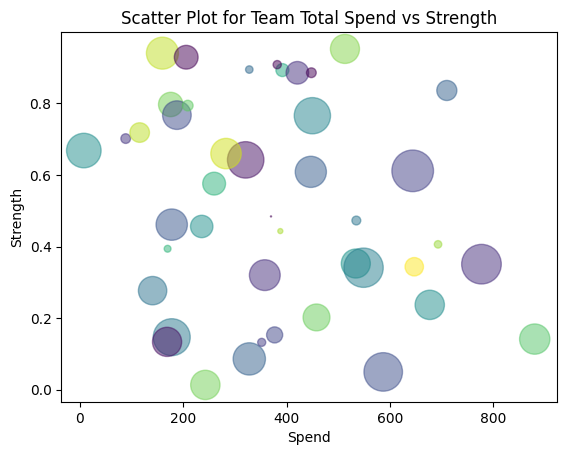

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats


df = team_spend_strength_df.toPandas()
N = len(df)
x = df['sum(price)']
y = df['strength']

#Compute Correlation
r,p = scipy.stats.spearmanr(x, y)
print(r,p)

colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y,s=area, c=colors, alpha=0.5)
plt.xlabel("Spend")
plt.ylabel("Strength")
plt.title("Scatter Plot for Team Total Spend vs Strength")
plt.show()

## 5. Continent with highest spending

In [ ]:
users_df = spark.read.csv("/content/users.csv", header=True, inferSchema=True)
users_df.show()

+-------------------+------+-----------+----------+----------+-------+
|          timestamp|userId|       nick|   twitter|       dob|country|
+-------------------+------+-----------+----------+----------+-------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|     PF|
|2012-06-23 17:40:35|    75|     fNWewX|   @OXqLyv|1979-11-12|     JO|
|2012-06-23 17:57:05|  2224|   rvXvUU9J|  @YexGCPm|1996-08-27|     GW|
|2012-

In [ ]:
updated_team_buy_user_df = updatedteam_buy_df.join(users_df,updatedteam_buy_df.userId == users_df.userId, how = "outer")
updated_team_buy_user_df.show(5)

+------+----------+-------------------+-------------------+--------------+------------+---------+----+-------------+------+------+-----+-----+---------+------+----+-------+----+-------+
|teamId|      name|   teamCreationTime|        teamEndTime|      strength|currentLevel|timestamp|txId|userSessionId|teamId|userId|buyId|price|timestamp|userId|nick|twitter| dob|country|
+------+----------+-------------------+-------------------+--------------+------------+---------+----+-------------+------+------+-----+-----+---------+------+----+-------+----+-------+
|     0|    8JqHAD|2016-06-14 19:32:57|9999-12-31 23:59:59|0.174879834235|           1|     null|null|         null|  null|  null| null| null|     null|  null|null|   null|null|   null|
|     1|Rlwjub4jqE|2016-06-13 14:20:52|9999-12-31 23:59:59|0.105268242757|           1|     null|null|         null|  null|  null| null| null|     null|  null|null|   null|null|   null|
|     3|    6nX33h|2016-06-14 07:15:48|9999-12-31 23:59:59|0.575897759

In [ ]:
!pip install pycountry_convert


In [ ]:
def country_to_continent(country_name):
  try:
    country_continent_code = pc.country_alpha2_to_continent_code(country_name)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
  except:
    return "None"

In [ ]:
import pycountry_convert as pc

#team_user_buying_df = team_user_buying_df.withColumn("continent", udf_country_to_continent(f.col("country") ))

updated_team_buy_user_df.withColumn("Continent",country_to_continent(updated_team_buy_user_df.col("country")))

updated_team_buy_user_df.show(8)

## 5. Top 10 Country With Highest Spending

In [ ]:
updated_team_buy_user_df.show(5)


+------+----------+-------------------+-------------------+--------------+------------+---------+----+-------------+------+------+-----+-----+---------+------+----+-------+----+-------+
|teamId|      name|   teamCreationTime|        teamEndTime|      strength|currentLevel|timestamp|txId|userSessionId|teamId|userId|buyId|price|timestamp|userId|nick|twitter| dob|country|
+------+----------+-------------------+-------------------+--------------+------------+---------+----+-------------+------+------+-----+-----+---------+------+----+-------+----+-------+
|     0|    8JqHAD|2016-06-14 19:32:57|9999-12-31 23:59:59|0.174879834235|           1|     null|null|         null|  null|  null| null| null|     null|  null|null|   null|null|   null|
|     1|Rlwjub4jqE|2016-06-13 14:20:52|9999-12-31 23:59:59|0.105268242757|           1|     null|null|         null|  null|  null| null| null|     null|  null|null|   null|null|   null|
|     3|    6nX33h|2016-06-14 07:15:48|9999-12-31 23:59:59|0.575897759

In [ ]:
from pyspark.sql.functions import desc

country_spend_df = updated_team_buy_user_df.groupBy('country').sum('price').orderBy(desc("sum(price)")).limit(10)
country_spend_df.show()

+-------+----------+
|country|sum(price)|
+-------+----------+
|     GD|     342.0|
|     IQ|     328.0|
|     PW|     324.0|
|     KY|     320.0|
|     BF|     313.0|
|     AO|     298.0|
|     AF|     296.0|
|     GF|     276.0|
|     VA|     274.0|
|     GU|     253.0|
+-------+----------+



<ipython-input-74-567630087a8e>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df['country'], rotation=60, horizontalalignment= 'right')


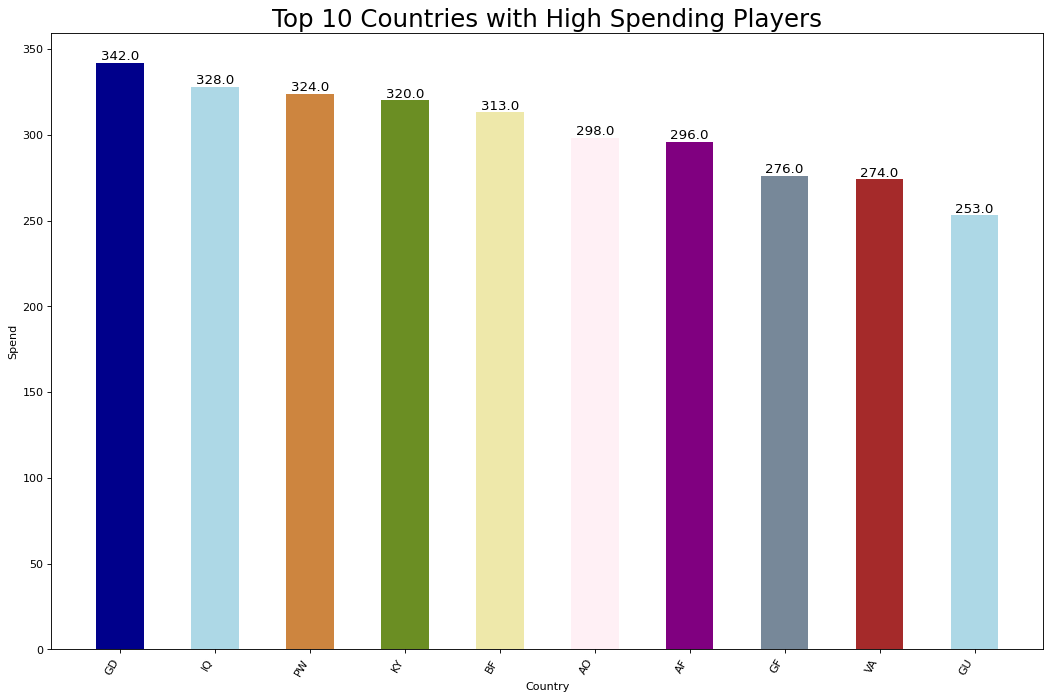

In [ ]:
import matplotlib.pyplot as plt
import random

df = country_spend_df.toPandas()

n = df['country'].unique().__len__()+1
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(df['country'], df['sum(price)'], color=c, width=.5)
for i, val in enumerate(df['sum(price)'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.gca().set_xticklabels(df['country'], rotation=60, horizontalalignment= 'right')
plt.title("Top 10 Countries with High Spending Players", fontsize=22)
plt.ylabel('Spend')
plt.xlabel('Country')
plt.show()


## 6. Highest Revenue giving product

In [ ]:
buy_df = spark.read.csv("/content/buy-clicks.csv", header=True, inferSchema=True)

In [ ]:
buy_df.show()

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|  11|  2222|    5| 20.0|
|2016-05-26 17:06:54|6094|         5798|  77|  1304|    5| 20.0|
|2016-05-26 18:06:54|6155|         5920|   9|  1027|    5| 20.0|
|2016-05-26 18:06:54|6156|         5697|  35|  2199|    2|  3.0|
|2016-05-26 18:36:54|6183|         5893|  64|  1544|    5| 20.0|
|2016-05-26 18:36:54|6184|         5697|  35|  2199|    1|  2.0|
|2016-05-26 19:36:54|6243|         5659|  13|  1623|    4| 10.0|
|2016-05-26 19:36:54|6244|         5920|   9|  1027|    3|  5.0|
|2016-05-26 20:06:54|6269

In [ ]:
from pyspark.sql.functions import desc

product_spend_df = buy_df.groupBy('buyId').sum('price')
product_spend_df.show()

+-----+----------+
|buyId|sum(price)|
+-----+----------+
|    1|     538.0|
|    3|    1685.0|
|    5|   12200.0|
|    4|    4250.0|
|    2|    2142.0|
|    0|     592.0|
+-----+----------+



In [ ]:
!pip install squarify


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import squarify 

(0.0, 100.0, 0.0, 100.0)

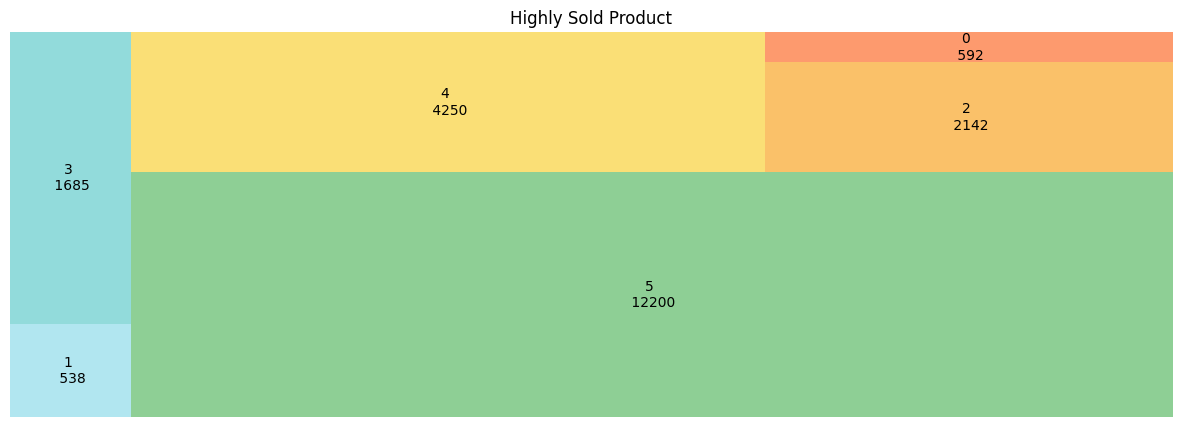

In [ ]:
plt.figure(figsize=(15,5))

df = product_spend_df.toPandas()

# Sample data
values = df['sum(price)']
labels = ['1 \n 538', '3 \n 1685', '5 \n 12200', '4 \n 4250', '2 \n 2142', '0 \n 592']

colors = ['#91DCEA', '#64CDCC', '#5FBB68',
          '#F9D23C', '#F9A729', '#FD6F30']
# Treemap
squarify.plot(sizes = values, label = labels,
              color = colors, alpha = 0.7)

plt.title('Highly Sold Product')

# Remove the axis:
plt.axis("off")

# plt.show() 

## 7. Number of times each item is purchased

In [ ]:

buy_df.show(5)

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|  11|  2222|    5| 20.0|
+-------------------+----+-------------+----+------+-----+-----+
only showing top 5 rows



In [ ]:
product_count_df = buy_df.groupBy('buyId').count()
product_count_df.show()

+-----+-----+
|buyId|count|
+-----+-----+
|    1|  269|
|    3|  337|
|    5|  610|
|    4|  425|
|    2|  714|
|    0|  592|
+-----+-----+



([<matplotlib.axis.YTick at 0x7f805479c070>,
 [Text(0, 1, '1'),
  Text(0, 3, '3'),
  Text(0, 5, '5'),
  Text(0, 4, '4'),
  Text(0, 2, '2'),
  Text(0, 0, '0')])

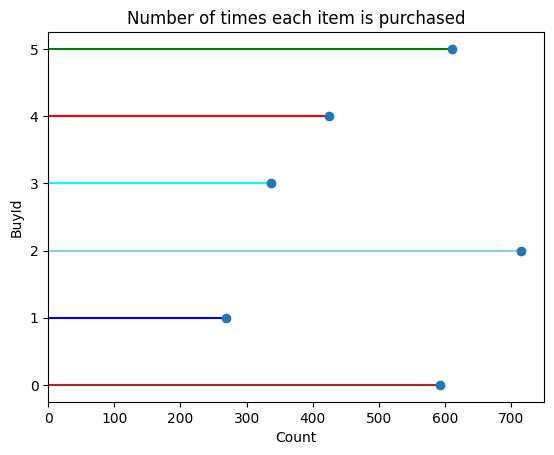

In [ ]:
# libraries
from pandas import *
import matplotlib.pyplot as plt
import numpy as np

data = product_count_df.toPandas()

# creating an empty chart
fig, axes = plt.subplots()

line_colors = ['blue', 'cyan', 'green', 'red',
               'skyblue', 'brown', 'yellow',
               'black', 'grey', 'orange', 'maroon',
               'lightgreen']
 
# plotting using plt.stem
axes.hlines(data['buyId'], xmin=0,
            xmax=data['count'], colors=line_colors)
  
# drawing the markers (circle)
axes.plot(data['count'], data['buyId'], "o")
axes.set_xlim(0)
  
# formatting and details
plt.xlabel('Count')
plt.ylabel('BuyId')
plt.title('Number of times each item is purchased')
plt.yticks(data['buyId'])

## 9. Amount spend by top 10 users

In [ ]:
users_df.show(5)

+-------------------+------+-----------+--------+----------+-------+
|          timestamp|userId|       nick| twitter|       dob|country|
+-------------------+------+-----------+--------+----------+-------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|@SZhyOHv|1994-07-20|     BA|
|2012-06-19 19:29:01|   949|    vAOfUkf|  @nkkNo|1971-04-22|     HU|
|2012-06-20 19:34:59|  1654|     qOOXSQ|  @SwOlw|1970-04-19|     IS|
|2012-06-21 01:18:29|  1586|    px4gW51|@IrCHTnE|1965-11-23|     AM|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc| @VJj0Az|1994-08-23|     CC|
+-------------------+------+-----------+--------+----------+-------+
only showing top 5 rows



In [ ]:
buy_df.show(5)

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|  11|  2222|    5| 20.0|
+-------------------+----+-------------+----+------+-----+-----+
only showing top 5 rows



In [ ]:
user_buy_df = users_df.join(buy_df,users_df.userId == buy_df.userId, how = "outer")
user_buy_df.show()

+-------------------+------+-----------+----------+----------+-------+-------------------+-----+-------------+----+------+-----+-----+
|          timestamp|userId|       nick|   twitter|       dob|country|          timestamp| txId|userSessionId|team|userId|buyId|price|
+-------------------+------+-----------+----------+----------+-------+-------------------+-----+-------------+----+------+-----+-----+
|2015-11-27 16:36:39|     0|  hAV9Ztqdv|@MnFe4LCVQ|1949-01-15|     UZ|               null| null|         null|null|  null| null| null|
|2012-12-17 03:25:44|     1|SmMidAFgJzx|   @fFMbCs|1980-12-02|     KM|2016-05-31 06:06:54|11790|        10041|  99|     1|    2|  3.0|
|2012-12-17 03:25:44|     1|SmMidAFgJzx|   @fFMbCs|1980-12-02|     KM|2016-05-31 06:36:54|11817|        10041|  99|     1|    2|  3.0|
|2012-12-17 03:25:44|     1|SmMidAFgJzx|   @fFMbCs|1980-12-02|     KM|2016-06-01 08:06:54|13447|        12713|  99|     1|    2|  3.0|
|2012-12-17 03:25:44|     1|SmMidAFgJzx|   @fFMbCs|1980

In [ ]:
user_spend_df = user_buy_df.groupBy('nick').sum('price').orderBy(desc("sum(price)")).limit(10)
user_spend_df.show()

+-----------+----------+
|       nick|sum(price)|
+-----------+----------+
|    YHxb6JJ|     223.0|
|QmA8GoqXpmN|     215.0|
|  Xqs8KSkOG|     202.0|
|     otRQLo|     200.0|
|   BtEYpQcB|     189.0|
| RSmlv6AHFU|     183.0|
|     dPFkHE|     183.0|
| hMaQpxTxv4|     180.0|
|     RgaYrK|     172.0|
| zknrWp1cio|     172.0|
+-----------+----------+



Text(0, 0.5, 'User Nickname')

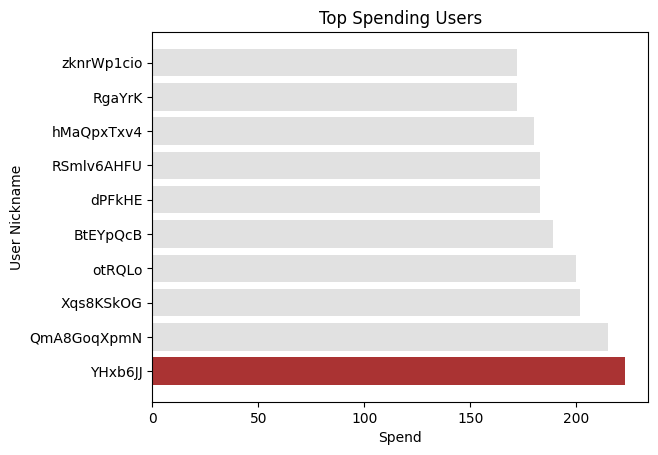

In [ ]:
import matplotlib.pyplot as plt

df = user_spend_df.toPandas()

fig = plt.figure()
ax = fig.add_subplot(111)

data_x = df['sum(price)']
data_y = df['nick']

ax.barh(data_y, data_x, color='#888888', alpha=0.25)

ax.barh(['YHxb6JJ'], [223], color='#aa3333')

plt.title("Top Spending Users")
plt.xlabel("Spend")
plt.ylabel("User Nickname")


## 10. Time series of In-game click ads

In [ ]:
ad_click_df = spark.read.csv("/content/ad-clicks.csv", header=True, inferSchema=True)
ad_click_df.show(5)

+-------------------+----+-------------+------+------+----+-----------+
|          timestamp|txId|userSessionId|teamId|userId|adId| adCategory|
+-------------------+----+-------------+------+------+----+-----------+
|2016-05-26 15:13:22|5974|         5809|    27|   611|   2|electronics|
|2016-05-26 15:17:24|5976|         5705|    18|  1874|  21|     movies|
|2016-05-26 15:22:52|5978|         5791|    53|  2139|  25|  computers|
|2016-05-26 15:22:57|5973|         5756|    63|   212|  10|    fashion|
|2016-05-26 15:22:58|5980|         5920|     9|  1027|  20|   clothing|
+-------------------+----+-------------+------+------+----+-----------+
only showing top 5 rows



In [ ]:
import pyspark.sql.functions as f

ad_click_df = ad_click_df.withColumn("tstamp",f.date_format(ad_click_df.timestamp,'yyyy-MM-dd') )
ad_click_df = ad_click_df.withColumn("hstamp",f.date_format(ad_click_df.timestamp,'hh:mm:ss') )
ad_click_df = ad_click_df.withColumn("month",f.date_format(ad_click_df.timestamp,'yyyy-MM-dd') )
ad_click_df = ad_click_df.select("month").groupBy("month").count().orderBy("count")




<Axes: title={'center': 'Time Series of Ad Clicks per Day'}, xlabel='Days', ylabel='Ads clicked'>

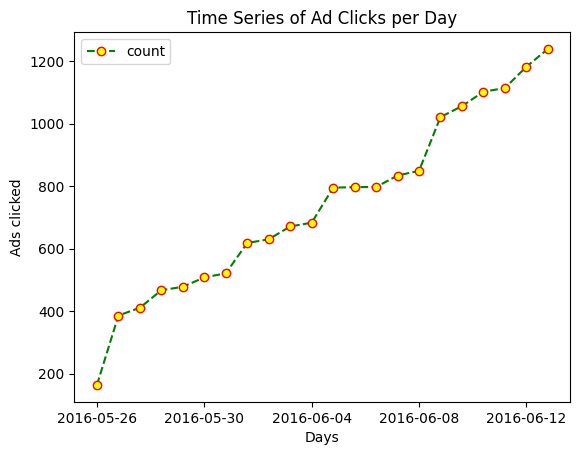

In [ ]:
df = ad_click_df.toPandas()
df

df.plot.line(x="month", y="count",color='green',linestyle='dashed', xlabel="Days", ylabel="Ads clicked", title="Time Series of Ad Clicks per Day",marker='o', markerfacecolor='yellow', markeredgecolor='red',)

##11. Users who bought items and never bought items

In [ ]:
users_df.show(5)

+-------------------+------+-----------+--------+----------+-------+
|          timestamp|userId|       nick| twitter|       dob|country|
+-------------------+------+-----------+--------+----------+-------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|@SZhyOHv|1994-07-20|     BA|
|2012-06-19 19:29:01|   949|    vAOfUkf|  @nkkNo|1971-04-22|     HU|
|2012-06-20 19:34:59|  1654|     qOOXSQ|  @SwOlw|1970-04-19|     IS|
|2012-06-21 01:18:29|  1586|    px4gW51|@IrCHTnE|1965-11-23|     AM|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc| @VJj0Az|1994-08-23|     CC|
+-------------------+------+-----------+--------+----------+-------+
only showing top 5 rows



In [ ]:
user_count = users_df.distinct().count()
user_count

2393

In [ ]:
buy_df.show(5)

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|  11|  2222|    5| 20.0|
+-------------------+----+-------------+----+------+-----+-----+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import countDistinct
buyer_df = buy_df.groupBy("buyId").agg(countDistinct('UserId'))
buyer_df.show()

+-----+-------------+
|buyId|count(UserId)|
+-----+-------------+
|    1|          194|
|    3|          232|
|    5|          248|
|    4|          234|
|    2|          274|
|    0|          198|
+-----+-------------+



In [ ]:
import plotly.graph_objects as go

labels = ['Bought an item','Never bought an item']
values = [1380,1013]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0,0.2])])
fig.show()

##12. Average Team Join

[Text(0.5, 0, 'Average number of times person joins a team'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Box Plot for statistics of players joining teams')]

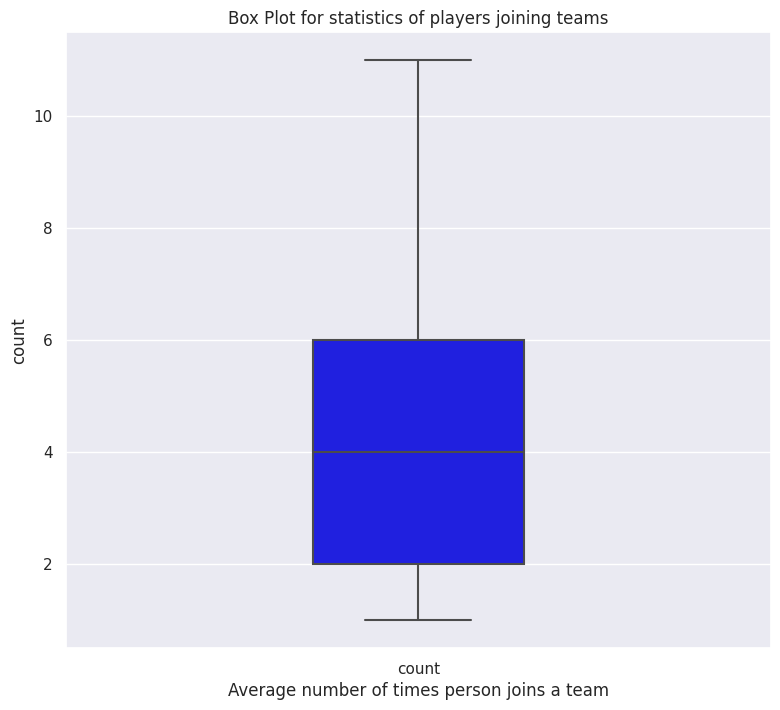

In [ ]:
import seaborn as sns 

team_assigment_df = spark.read.csv("/content/team-assignments.csv", header=True, inferSchema=True)


team_assigment_stats_df = team_assigment_df.groupBy("userId").agg(f.count("userId").alias("count")).select("count","userId").orderBy("count")
x = team_assigment_stats_df.select("count").toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
#ax = sns.boxplot(data=x, palette="Set3",color="green")
ax = sns.boxplot(data=x,color="blue",width=0.3)
ax.set(xlabel='Average number of times person joins a team', ylabel='count', 
       title = "Box Plot for statistics of players joining teams")





[Text(0.5, 0, 'Count of time person joins a team'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Violin Plot for statistics of players joining teams')]

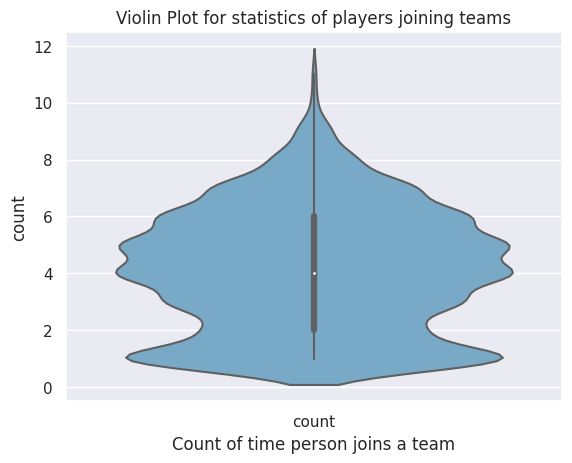

In [ ]:
#ax = fig.add_subplot(1, 2, 2)
sns.set(style="darkgrid")
ax = sns.violinplot(data=x, palette = "Blues")
ax.set(xlabel='Count of time person joins a team', ylabel='count', title = "Violin Plot for statistics of players joining teams")